<a href="https://colab.research.google.com/github/farkoo/Cat-Dog-Classifier/blob/master/CI_HW3_CatDogClassifier_Part1_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Prepare train and test data

In [17]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
%%bash
git clone "https://github.com/MKasaei00/IUT-CI-HW3-cat-dog-classifier.git"

Cloning into 'IUT-CI-HW3-cat-dog-classifier'...


In [4]:
%cd IUT-CI-HW3-cat-dog-classifier

/content/drive/MyDrive/IUT-CI-HW3-cat-dog-classifier


In [ ]:
%%bash
7z x dataset/test_set.zip -odataset
7z x dataset/training_set.zip -odataset


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 3711630 bytes (3625 KiB)

Extracting archive: dataset/test_set.zip
--
Path = dataset/test_set.zip
Type = zip
Physical Size = 3711630
Embedded Stub Size = 4
Total Physical Size = 45654670
Multivolume = +
Volume Index = 2
Volumes = 3

Everything is Ok

Folders: 3
Files: 2000
Size:       45739128
Compressed: 45654670

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 13986903 bytes (14 MiB)

Extracting archive: dataset/training_set.zip
--
Path = dataset/training_set.zip
Type = zip
Physical Size = 13986903
Embedded Stub Size = 4
Total Physical Size = 181759063
Multivolum

In [6]:
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
def get_image_shapes(dir,count_limit = 10):
  shapes = {}
  for category in os.listdir(dir):
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      img = cv2.imread(img_path)
      shape = img.shape
      if shape not in shapes:
        shapes[shape] = 1
      else:
        shapes[shape] = shapes[shape] + 1
      
  return sorted(shapes.items(),key=lambda item : -item[1])[:count_limit]

In [ ]:
test_dir = 'dataset/test_set'
training_dir = 'dataset/training_set'

In [ ]:
def load_data_from_directory(dir,width,height,classes):
  img_data = []
  img_label = []
  categories = os.listdir(dir)
  for category in categories:
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      img = cv2.imread(img_path)
      img = cv2.resize(img,(width,height))
      # cv2_imshow(img)
      img = np.array(img).astype('float32') / 255
      
      img_data.append(img)
      img_label.append(category)

  img_label = np_utils.to_categorical([categories.index(label) for label in img_label],classes,dtype=np.ubyte)
  img_data = np.array(img_data)
  img_label = np.array(img_label)

  randomize = np.arange(len(img_data))
  np.random.shuffle(randomize)
  img_data = img_data[randomize]
  img_label = img_label[randomize]

  return img_data , img_label

In [7]:
classes = 2
w = 128
h = 128

In [ ]:
train_x , train_label = load_data_from_directory(training_dir,w,h,classes)
test_x , test_label = load_data_from_directory(test_dir,w,h,classes)

In [ ]:
train_x.shape,train_label.shape,test_x.shape,test_label.shape

((8000, 128, 128, 3), (8000, 2), (2000, 128, 128, 3), (2000, 2))

In [ ]:
!rm -rf cleanData
!mkdir cleanData
np.save('cleanData/train_x.npy',train_x)
np.save('cleanData/train_label.npy',train_label)
np.save('cleanData/test_x.npy',test_x)
np.save('cleanData/test_label.npy',test_label)

In [8]:
train_x = np.load('cleanData/train_x.npy')
train_label = np.load('cleanData/train_label.npy')
test_x = np.load('cleanData/test_x.npy')
test_label = np.load('cleanData/test_label.npy')

In [ ]:
len(train_x) , len(train_label),len(test_x),len(test_label)

(8000, 8000, 2000, 2000)

# Generate Neural Network

In [9]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,LeakyReLU
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.initializers import RandomNormal

In [ ]:
def train_model(config):
  model = Sequential()

  model.add(Flatten(input_shape=(h,w,3)))
  model.add(Dropout(config['in_drop_out']))

  for act ,drop_out, layers in config['layers']:
    for layer in layers:
      model.add(Dense(layer))
      model.add(act())
      model.add(Dropout(drop_out))

  model.compile(
    optimizer=Adam(config['learning_rate']),
    loss=categorical_crossentropy,
    metrics=['accuracy']
  )

  history = model.fit(train_x,train_label,
                    batch_size=config['batch'],
                    epochs = config['epochs'],
                    shuffle=True,
                    validation_data=(test_x,test_label))
  
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'],loc='lower right')
  plt.show()

# Initial model, Without any dropout and data augmentation

In [ ]:
train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100
})

Epoch 1/300
32/32 [==============================] - 4s 80ms/step - loss: 0.6973 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 2/300
32/32 [==============================] - 2s 69ms/step - loss: 0.6944 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/300
32/32 [==============================] - 2s 67ms/step - loss: 0.6934 - accuracy: 0.4934 - val_loss: 0.6930 - val_accuracy: 0.5115
Epoch 4/300
32/32 [==============================] - 2s 69ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy: 0.5005
Epoch 5/300
32/32 [==============================] - 2s 69ms/step - loss: 0.6927 - accuracy: 0.5149 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/300
32/32 [==============================] - 2s 68ms/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 7/300
32/32 [==============================] - 2s 68ms/step - loss: 0.6928 - accuracy: 0.5086 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 

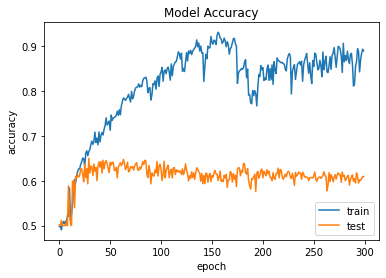

In [ ]:
train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.05,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]),
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':300
})

Epoch 1/300
32/32 [==============================] - 4s 77ms/step - loss: 0.7025 - accuracy: 0.4952 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/300
32/32 [==============================] - 2s 68ms/step - loss: 0.6979 - accuracy: 0.5021 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/300
32/32 [==============================] - 2s 69ms/step - loss: 0.6946 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/300
32/32 [==============================] - 2s 68ms/step - loss: 0.6936 - accuracy: 0.5059 - val_loss: 0.6930 - val_accuracy: 0.5230
Epoch 5/300
32/32 [==============================] - 2s 68ms/step - loss: 0.6941 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 6/300
32/32 [==============================] - 2s 69ms/step - loss: 0.6940 - accuracy: 0.4981 - val_loss: 0.6928 - val_accuracy: 0.5360
Epoch 7/300
32/32 [==============================] - 2s 70ms/step - loss: 0.6928 - accuracy: 0.5077 - val_loss: 0.6925 - val_accuracy: 0.5415
Epoch 

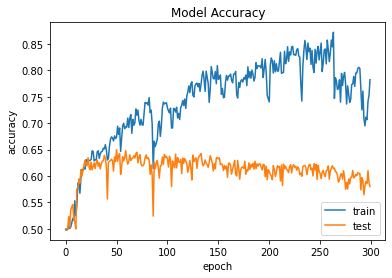

In [ ]:
train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.15,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]),
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':300
})

Epoch 1/300
32/32 [==============================] - 4s 76ms/step - loss: 0.7236 - accuracy: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.5340
Epoch 2/300
32/32 [==============================] - 2s 68ms/step - loss: 0.7000 - accuracy: 0.5033 - val_loss: 0.6931 - val_accuracy: 0.4955
Epoch 3/300
32/32 [==============================] - 2s 69ms/step - loss: 0.6973 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/300
32/32 [==============================] - 2s 69ms/step - loss: 0.6950 - accuracy: 0.5041 - val_loss: 0.6931 - val_accuracy: 0.4960
Epoch 5/300
32/32 [==============================] - 2s 69ms/step - loss: 0.6950 - accuracy: 0.5065 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 6/300
32/32 [==============================] - 2s 69ms/step - loss: 0.6932 - accuracy: 0.5271 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/300
32/32 [==============================] - 2s 69ms/step - loss: 0.6947 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 

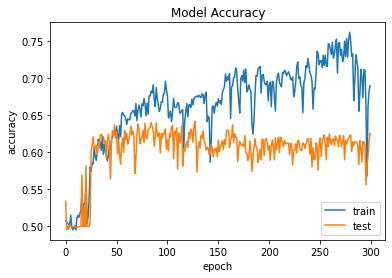

In [ ]:
train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.25,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]),
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':300
})

Epoch 1/300
32/32 [==============================] - 4s 77ms/step - loss: 0.8651 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/300
32/32 [==============================] - 2s 68ms/step - loss: 0.7122 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/300
32/32 [==============================] - 2s 68ms/step - loss: 0.7094 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/300
32/32 [==============================] - 2s 67ms/step - loss: 0.7043 - accuracy: 0.4886 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/300
32/32 [==============================] - 2s 68ms/step - loss: 0.7019 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/300
32/32 [==============================] - 2s 67ms/step - loss: 0.6981 - accuracy: 0.4932 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/300
32/32 [==============================] - 2s 68ms/step - loss: 0.6966 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 

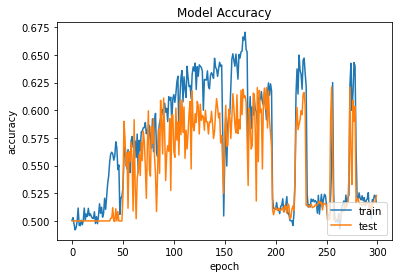

In [ ]:
train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.35,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]),
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':300
})

Epoch 1/500
32/32 [==============================] - 4s 84ms/step - loss: 0.8353 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/500
32/32 [==============================] - 2s 69ms/step - loss: 0.7160 - accuracy: 0.5054 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/500
32/32 [==============================] - 2s 68ms/step - loss: 0.7060 - accuracy: 0.5046 - val_loss: 0.6931 - val_accuracy: 0.4965
Epoch 4/500
32/32 [==============================] - 2s 68ms/step - loss: 0.7062 - accuracy: 0.4872 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/500
32/32 [==============================] - 2s 66ms/step - loss: 0.7038 - accuracy: 0.4915 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/500
32/32 [==============================] - 2s 66ms/step - loss: 0.6966 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/500
32/32 [==============================] - 2s 68ms/step - loss: 0.6987 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 

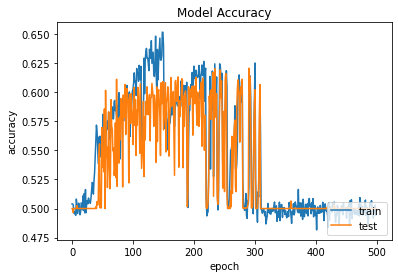

In [ ]:
train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.35,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]),
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':500
})

Epoch 1/300
32/32 [==============================] - 3s 59ms/step - loss: 0.7862 - accuracy: 0.4948 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/300
32/32 [==============================] - 2s 52ms/step - loss: 0.7093 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/300
32/32 [==============================] - 2s 54ms/step - loss: 0.6999 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/300
32/32 [==============================] - 2s 54ms/step - loss: 0.6970 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/300
32/32 [==============================] - 2s 53ms/step - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/300
32/32 [==============================] - 2s 53ms/step - loss: 0.6938 - accuracy: 0.5076 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/300
32/32 [==============================] - 2s 54ms/step - loss: 0.6947 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 

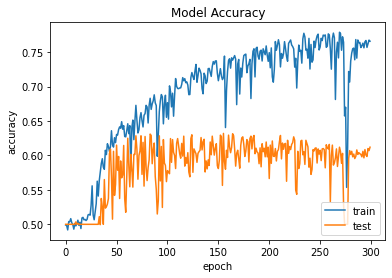

In [ ]:
train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.1,[2000,1600,800,600,500]),
          (lambda : Activation('relu'),0.2,[400]*3),
          (lambda : Activation('relu'),0.35,[400]*5),
          (lambda : Activation('relu'),0.5,[300,250,200,150,120]),
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':300
})

In [ ]:
train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.1,[2000,1600,800,600,500]),
          (lambda : Activation('relu'),0.2,[400]*3),
          (lambda : Activation('relu'),0.35,[400]*5),
          (lambda : Activation('relu'),0.5,[300,250,200,150,120]),
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':1024,
    'epochs':1000
})

Epoch 1/1000
8/8 [==============================] - 3s 206ms/step - loss: 0.7414 - accuracy: 0.5063 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/1000
8/8 [==============================] - 1s 171ms/step - loss: 0.7208 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/1000
8/8 [==============================] - 1s 170ms/step - loss: 0.7035 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/1000
8/8 [==============================] - 1s 171ms/step - loss: 0.7018 - accuracy: 0.4885 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/1000
8/8 [==============================] - 1s 159ms/step - loss: 0.6993 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/1000
8/8 [==============================] - 1s 176ms/step - loss: 0.6978 - accuracy: 0.4872 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/1000
8/8 [==============================] - 1s 169ms/step - loss: 0.6943 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 



# Add Data Augmentation


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.04,
      height_shift_range=0.04,
      shear_range=0.04,
      zoom_range=0.04,
      horizontal_flip=True,
      fill_mode='nearest'
)

train_generator = train_datagen.flow(train_x, train_label, batch_size = 256)

In [ ]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow(
    test_x,
    test_label,
    batch_size=256)

In [ ]:
def train_model(config):
  model = Sequential()

  model.add(Flatten(input_shape=(h,w,3)))
  model.add(Dropout(config['in_drop_out']))

  for act ,drop_out, layers in config['layers']:
    for layer in layers:
      model.add(Dense(layer))
      model.add(act())
      model.add(Dropout(drop_out))

  model.compile(
    optimizer=Adam(config['learning_rate']),
    loss=categorical_crossentropy,
    metrics=['accuracy']
  )

  
  
  train_steps = 8000/float(config['batch'])
  validation_steps = 2000/float(config['batch'])

  history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps,
                    epochs = config['epochs'],
                    validation_data=validation_generator,
                   validation_steps=validation_steps,
                   )
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'],loc='lower right')
  plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/120
31/31 [==============================] - 24s 732ms/step - loss: 0.6948 - accuracy: 0.5124 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/120
31/31 [==============================] - 23s 728ms/step - loss: 0.6951 - accuracy: 0.4948 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/120
31/31 [==============================] - 23s 722ms/step - loss: 0.6934 - accuracy: 0.5131 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/120
31/31 [==============================] - 23s 734ms/step - loss: 0.6930 - accuracy: 0.5083 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/120
31/31 [==============================] - 23s 726ms/step - loss: 0.6931 - accuracy: 0.5077 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 6/120
31/31 [==============================] - 23s 724ms/step - loss: 0.6933 - accuracy: 0.5064 - val_loss: 0.6920 - val_accuracy: 0.5025
Epoch 7/120
31/31 [==============================] - 23s 730ms/step - loss: 0.6904 - accuracy: 0.5423 - val_loss: 0.6799 - val_accuracy:

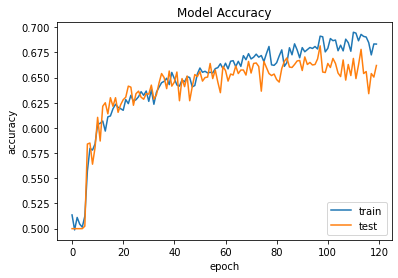

In [ ]:
train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':120
})
# 0.03, 0 -> 68

# Seprate validation data and Evaluate model

In [11]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_Label, valid_Label = train_test_split(train_x, train_label, test_size = 0.2, random_state = 13)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.04,
      height_shift_range=0.04,
      shear_range=0.04,
      zoom_range=0.04,
      horizontal_flip=True,
      fill_mode='nearest'
)

train_generator = train_datagen.flow(train_X, train_Label, batch_size = 256)

In [13]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow(
    valid_X,
    valid_Label,
    batch_size=256)

In [ ]:
def train_model(config):
  model = Sequential()

  model.add(Flatten(input_shape=(h,w,3)))
  model.add(Dropout(config['in_drop_out']))

  for act ,drop_out, layers in config['layers']:
    for layer in layers:
      model.add(Dense(layer))
      model.add(act())
      model.add(Dropout(drop_out))

  model.compile(
    optimizer=Adam(config['learning_rate']),
    loss=categorical_crossentropy,
    metrics=['accuracy']
  )

  
  
  train_steps = 6400/float(config['batch'])
  validation_steps = 1600/float(config['batch'])

  history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps,
                    epochs = config['epochs'],
                    validation_data=validation_generator,
                   validation_steps=validation_steps,
                   )
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'],loc='lower right')
  plt.show()

  return model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
25/25 [==============================] - 20s 740ms/step - loss: 0.6954 - accuracy: 0.4976 - val_loss: 0.6934 - val_accuracy: 0.4919
Epoch 2/100
25/25 [==============================] - 18s 738ms/step - loss: 0.6931 - accuracy: 0.5110 - val_loss: 0.6932 - val_accuracy: 0.5081
Epoch 3/100
25/25 [==============================] - 18s 735ms/step - loss: 0.6937 - accuracy: 0.4890 - val_loss: 0.6931 - val_accuracy: 0.5450
Epoch 4/100
25/25 [==============================] - 18s 731ms/step - loss: 0.6932 - accuracy: 0.5085 - val_loss: 0.6930 - val_accuracy: 0.5306
Epoch 5/100
25/25 [==============================] - 19s 745ms/step - loss: 0.6927 - accuracy: 0.5339 - val_loss: 0.6918 - val_accuracy: 0.5125
Epoch 6/100
25/25 [==============================] - 18s 728ms/step - loss: 0.6909 - accuracy: 0.5410 - val_loss: 0.6855 - val_accuracy: 0.5512
Epoch 7/100
25/25 [==============================] - 19s 740ms/step - loss: 0.6789 - accuracy: 0.5732 - val_loss: 0.6829 - val_accuracy:

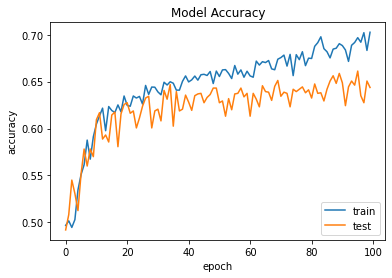

In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100
})
# 0.03, 0 -> 68

In [ ]:
test_eval = model.evaluate(test_x, test_label, verbose = 0)

In [ ]:
print('Test loss: ', test_eval[0])
print('Test accuracy: ', test_eval[1])

Test loss:  0.6182146072387695
Test accuracy:  0.6424999833106995


# With augmentation more testing 

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_X, valid_X, train_Label, valid_Label = train_test_split(train_x, train_label, test_size = 0.2, random_state = 13)

In [15]:
def train_model(config):
  model = Sequential()

  model.add(Flatten(input_shape=(h,w,3)))
  model.add(Dropout(config['in_drop_out']))

  for act ,drop_out, layers in config['layers']:
    for layer in layers:
      model.add(Dense(layer))
      model.add(act())
      model.add(Dropout(drop_out))

  model.compile(
    optimizer=Adam(config['learning_rate']),
    loss=categorical_crossentropy,
    metrics=['accuracy']
  )

  train_datagen = ImageDataGenerator(
        rotation_range=config['aug_rotation'],
        width_shift_range=config['aug_shift_w'],
        height_shift_range=config['aug_shift_h'],
        shear_range=config['aug_shear'],
        zoom_range=config['aug_zoom'],
        horizontal_flip=config['aug_horizontal_flip'],
        fill_mode='nearest'
  )

  train_generator = train_datagen.flow(train_X, train_Label, batch_size = config['batch'])

  validation_datagen = ImageDataGenerator()
  validation_generator = validation_datagen.flow(valid_X,valid_Label,batch_size=256)

  history = model.fit(train_generator,
                      validation_data=validation_generator,
                      epochs = config['epochs'],
                    )
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'],loc='lower right')
  plt.show()

  test_eval = model.evaluate(test_x, test_label, verbose = 0)
  print('Test loss: ', test_eval[0])
  print('Test accuracy: ', test_eval[1])

  return model

Epoch 1/100
25/25 [==============================] - 20s 750ms/step - loss: 0.6962 - accuracy: 0.4892 - val_loss: 0.6931 - val_accuracy: 0.5125
Epoch 2/100
25/25 [==============================] - 19s 745ms/step - loss: 0.6934 - accuracy: 0.5130 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 3/100
25/25 [==============================] - 19s 744ms/step - loss: 0.6935 - accuracy: 0.4988 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 4/100
25/25 [==============================] - 19s 750ms/step - loss: 0.6933 - accuracy: 0.5075 - val_loss: 0.6931 - val_accuracy: 0.5094
Epoch 5/100
25/25 [==============================] - 19s 742ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 6/100
25/25 [==============================] - 19s 746ms/step - loss: 0.6933 - accuracy: 0.4924 - val_loss: 0.6931 - val_accuracy: 0.5175
Epoch 7/100
25/25 [==============================] - 19s 743ms/step - loss: 0.6932 - accuracy: 0.5090 - val_loss: 0.6930 - val_accuracy:

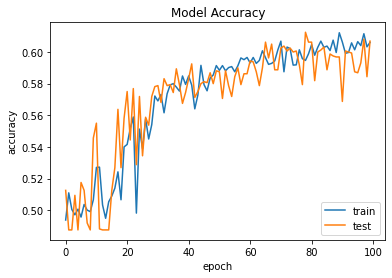

Test loss:  0.6431811451911926
Test accuracy:  0.6209999918937683


In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':90,
    'aug_shift_w':0.1,
    'aug_shift_h':0.1,
    'aug_shear':0.04,
    'aug_zoom':0.2,
    'aug_horizontal_flip':True
})

Epoch 1/120
25/25 [==============================] - 20s 757ms/step - loss: 0.6999 - accuracy: 0.4901 - val_loss: 0.6941 - val_accuracy: 0.4875
Epoch 2/120
25/25 [==============================] - 19s 741ms/step - loss: 0.6930 - accuracy: 0.5116 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 3/120
25/25 [==============================] - 19s 749ms/step - loss: 0.6933 - accuracy: 0.4954 - val_loss: 0.6930 - val_accuracy: 0.5125
Epoch 4/120
25/25 [==============================] - 19s 741ms/step - loss: 0.6933 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 5/120
25/25 [==============================] - 18s 738ms/step - loss: 0.6932 - accuracy: 0.5118 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/120
25/25 [==============================] - 19s 744ms/step - loss: 0.6930 - accuracy: 0.5100 - val_loss: 0.6935 - val_accuracy: 0.4925
Epoch 7/120
25/25 [==============================] - 19s 743ms/step - loss: 0.6925 - accuracy: 0.5093 - val_loss: 0.6908 - val_accuracy:

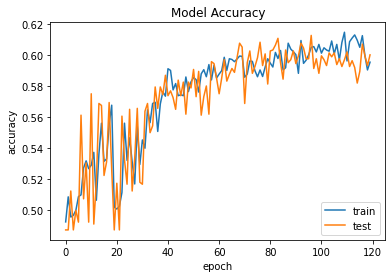

Test loss:  0.6515750885009766
Test accuracy:  0.6294999718666077


In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.05,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':6e-4,
    'batch':256,
    'epochs':120,
    'aug_rotation':90,
    'aug_shift_w':0.1,
    'aug_shift_h':0.1,
    'aug_shear':0.04,
    'aug_zoom':0.2,
    'aug_horizontal_flip':True
})

Epoch 1/200
25/25 [==============================] - 22s 749ms/step - loss: 0.6953 - accuracy: 0.4920 - val_loss: 0.6930 - val_accuracy: 0.4944
Epoch 2/200
25/25 [==============================] - 19s 755ms/step - loss: 0.6945 - accuracy: 0.4866 - val_loss: 0.6932 - val_accuracy: 0.4913
Epoch 3/200
25/25 [==============================] - 19s 763ms/step - loss: 0.6934 - accuracy: 0.4871 - val_loss: 0.6934 - val_accuracy: 0.4919
Epoch 4/200
25/25 [==============================] - 19s 766ms/step - loss: 0.6935 - accuracy: 0.4975 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 5/200
25/25 [==============================] - 19s 752ms/step - loss: 0.6936 - accuracy: 0.4946 - val_loss: 0.6938 - val_accuracy: 0.4956
Epoch 6/200
25/25 [==============================] - 19s 759ms/step - loss: 0.6924 - accuracy: 0.5125 - val_loss: 0.6929 - val_accuracy: 0.5069
Epoch 7/200
25/25 [==============================] - 19s 770ms/step - loss: 0.6931 - accuracy: 0.5122 - val_loss: 0.6932 - val_accuracy:

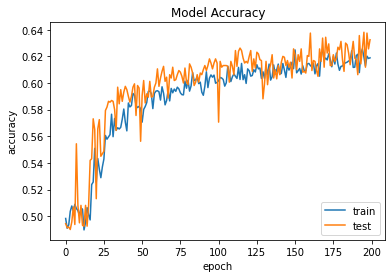

Test loss:  0.6287726759910583
Test accuracy:  0.6294999718666077


In [16]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.04,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':200,
    'aug_rotation':90,
    'aug_shift_w':0.1,
    'aug_shift_h':0.1,
    'aug_shear':0.04,
    'aug_zoom':0.2,
    'aug_horizontal_flip':True
})

Epoch 1/200
25/25 [==============================] - 20s 756ms/step - loss: 0.6960 - accuracy: 0.4856 - val_loss: 0.6952 - val_accuracy: 0.4875
Epoch 2/200
25/25 [==============================] - 19s 747ms/step - loss: 0.6948 - accuracy: 0.4978 - val_loss: 0.6950 - val_accuracy: 0.4875
Epoch 3/200
25/25 [==============================] - 19s 745ms/step - loss: 0.6929 - accuracy: 0.5108 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 4/200
25/25 [==============================] - 19s 743ms/step - loss: 0.6934 - accuracy: 0.4964 - val_loss: 0.6931 - val_accuracy: 0.4875
Epoch 5/200
25/25 [==============================] - 19s 743ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 6/200
25/25 [==============================] - 19s 740ms/step - loss: 0.6934 - accuracy: 0.4996 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 7/200
25/25 [==============================] - 19s 748ms/step - loss: 0.6939 - accuracy: 0.4922 - val_loss: 0.6937 - val_accuracy:

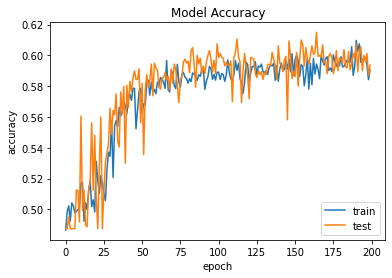

Test loss:  0.6455475687980652
Test accuracy:  0.6269999742507935


In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.04,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':200,
    'aug_rotation':90,
    'aug_shift_w':0.25,
    'aug_shift_h':0.25,
    'aug_shear':0.25,
    'aug_zoom':0.25,
    'aug_horizontal_flip':True
})

In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.20,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':200,
    'aug_rotation':90,
    'aug_shift_w':0.25,
    'aug_shift_h':0.25,
    'aug_shear':0.25,
    'aug_zoom':0.25,
    'aug_horizontal_flip':True
})

# Report: Accuracy, Precision, Recall, F1-measure

In [1]:
predictes_classes = model.predict(test_X)
predicted_classes = np.argmax(np.round(predicted_classes), axis = 1)

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) in range(num_classes)]
print(classification_report(test_label, predicted_classes, target_names = target_names))